In [2]:
#Multi-Layer Perceptron with MNIST
from IPython.display import Image

In [3]:
#Sample of Images
Image(url= "http://3.bp.blogspot.com/_UpN7DfJA0j4/TJtUBWPk0SI/AAAAAAAAABY/oWPMtmqJn3k/s1600/mnist_originals.png", width=200, height=200)

In [5]:
from __future__ import print_function
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import os
import sys
import cntk as C
import cntk.tests.test_utils
cntk.tests.test_utils.set_device_from_pytest_env()
C.cntk_py.set_fixed_random_seed(1)

%matplotlib inline

In [8]:
#Define data dimensions
input_dim=784
num_output_classes=10

In [9]:
#Read a CTF formatted text using a CTF Deserializer from a file
def create_reader(path, is_training, input_dim, num_label_classes):
    return C.io.MinibatchSource(C.io.CTFDeserializer(path, C.io.StreamDefs(
        labels=C.io.StreamDef(field='labels', shape=num_label_classes, is_sparse=False),
        features=C.io.StreamDef(field='features', shape=input_dim, is_sparse=False)
    )), randomize=is_training, max_sweeps=C.io.INFINITELY_REPEAT if is_training else 1)

In [16]:
# Ensure the training and test data is generated and available for this tutorial.
# We search in two locations in the toolkit for the cached MNIST data set.
data_found = False
for data_dir in [os.path.join("..", "Examples", "Image", "DataSets", "MNIST"),
                 os.path.join("data", "MNIST")]:
    train_file = os.path.join(data_dir, "Train-28x28_cntk_text.txt")
    test_file = os.path.join(data_dir, "Test-28x28_cntk_text.txt")
    if os.path.isfile(train_file) and os.path.isfile(test_file):
        data_found = True
        break
if not data_found:
    raise ValueError("Please generate the data by completing CNTK 103 Part A")
print("Data directory is {0}".format(data_dir))

Data directory is data\MNIST


In [18]:
#Model Creation
num_hidden_layers=2
hidden_layers_dim=400
input=C.input_variable(input_dim)
label=C.input_variable(num_output_classes)

In [19]:
#Multi-layer perceptron setup
def create_model(features):
    with C.layers.default_options(init=C.layers.glorot_uniform(), activation=C.ops.relu):
        h=features
        for _ in range(num_hidden_layers):
            h=C.layers.Dense(hidden_layers_dim)(h)
            r=C.layers.Dense(num_output_classes, activation=None)(h)
            return r
z=create_model(input)

In [21]:
#Scale the input in the range of 0-1 by dividing it with 255
z=create_model(input/255)

In [23]:
#Learning model parameters

#Training
loss=C.cross_entropy_with_softmax(z, label)

In [24]:
#Evaluation
label_error=C.classification_error(z, label)

In [25]:
#Configure training

#Instatntiate the training object to drive the model training
learning_rate=0.2
lr_schedule=C.learning_parameter_schedule(learning_rate)
learner=C.sgd(z.parameters, lr_schedule)
trainer=C.Trainer(z, (loss, label_error), [learner])

In [26]:
#Define a utility function to compute the moving average sum
#An efficient implementation is possible with np.cumsum() function
def moving_average(a, w=5):
    if len(a)< w:
        return a[:] #Need to send a copy of the array
    return [val if idx < w  else sum(a[(idx-w):idx])/w for idx, val in enumerate(a)]

#Define a utility that prints the training progress
def print_training_progress(trainer, mb, frequency, verbose=1):
    training_loss="NA"
    eval_error="NA"
    
    if mb%frequency ==0 :
        training_loss= trainer.previous_minibatch_loss_average
        eval_error=trainer.previous_minibatch_evaluation_average
        if verbose:
            print("Minibatch: {0}, Loss: {1:.4f}, Error: {2:.2f}%".format(mb, training_loss, eval_error*100))
            
    return mb, training_loss, eval_error
    


In [28]:
#Run the trainer

#Initialize the parameters for the trainer
minibatch_size=64
num_samples_per_sweep=60000
num_sweeps_to_train_with=10
num_minibatches_to_train= (num_samples_per_sweep*num_sweeps_to_train_with)/minibatch_size

In [30]:
#Create the reader to training dataset
reader_train=create_reader(train_file, True, input_dim, num_output_classes)

#Map the data streams to the input labels
input_map={
    label: reader_train.streams.labels,
    input: reader_train.streams.features
}

#Run the trainer on and perform model training
training_progress_output_freq=500

plotdata={"batchsize": [], "loss": [], "error":[]}

for i in range(0, int(num_minibatches_to_train)):
    
    #Read a minibatch from the training data file
    data=reader_train.next_minibatch(minibatch_size, input_map=input_map)
    
    trainer.train_minibatch(data)
    batchsize, loss, error=print_training_progress(trainer, i, training_progress_output_freq, verbose=1)
    
    if not (loss=="NA" or error =="NA"):
        plotdata["batchsize"].append(batchsize)
        plotdata["loss"].append(loss)
        plotdata["error"].append(error)

Minibatch: 0, Loss: 2.2645, Error: 85.94%
Minibatch: 500, Loss: 0.3232, Error: 12.50%
Minibatch: 1000, Loss: 0.1045, Error: 1.56%
Minibatch: 1500, Loss: 0.1754, Error: 7.81%
Minibatch: 2000, Loss: 0.0321, Error: 0.00%
Minibatch: 2500, Loss: 0.0446, Error: 1.56%
Minibatch: 3000, Loss: 0.0126, Error: 0.00%
Minibatch: 3500, Loss: 0.0649, Error: 1.56%
Minibatch: 4000, Loss: 0.0767, Error: 3.12%
Minibatch: 4500, Loss: 0.0690, Error: 3.12%
Minibatch: 5000, Loss: 0.0279, Error: 1.56%
Minibatch: 5500, Loss: 0.0097, Error: 0.00%
Minibatch: 6000, Loss: 0.0235, Error: 0.00%
Minibatch: 6500, Loss: 0.0236, Error: 0.00%
Minibatch: 7000, Loss: 0.0113, Error: 0.00%
Minibatch: 7500, Loss: 0.0269, Error: 1.56%
Minibatch: 8000, Loss: 0.0076, Error: 0.00%
Minibatch: 8500, Loss: 0.0086, Error: 0.00%
Minibatch: 9000, Loss: 0.0159, Error: 0.00%


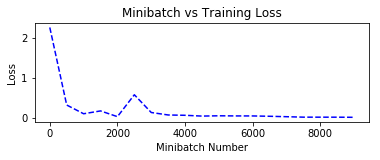

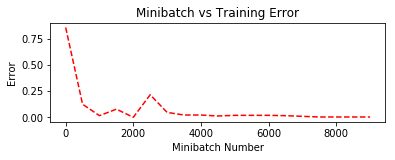

In [31]:
#Compute the moving average loss to smooth out the loss in SGD
plotdata["avgloss"]=moving_average(plotdata["loss"])
plotdata["avgerror"]=moving_average(plotdata["error"])

#plot the training loss and training error

plt.figure(1)
plt.subplot(211)
plt.plot(plotdata["batchsize"], plotdata["avgloss"], 'b--')
plt.xlabel("Minibatch Number")
plt.ylabel("Loss")
plt.title("Minibatch vs Training Loss")

plt.show()


plt.subplot(212)
plt.plot(plotdata["batchsize"], plotdata["avgerror"], 'r--')
plt.xlabel("Minibatch Number")
plt.ylabel("Error")
plt.title("Minibatch vs Training Error")

plt.show()
         

In [34]:
#Run eavluation/testing

#Read the test data
reader_test=create_reader(test_file, False, input_dim, num_output_classes)

test_input_map={
    label: reader_test.streams.labels,
    input: reader_test.streams.features
}


#Test data for trained model
test_minibatch_size=512
num_samples=10000
num_minibatches_to_test=num_samples//test_minibatch_size
test_result=0.0

for i in range(num_minibatches_to_test):
    #We are loading test data in batches specified by the test_minibatch_size
    #Easch data pont in the minibatch is an MNIST digit image of 784 dimensions
    #with one pixel per dimension that will encode/decode with the trained model
    data=reader_test.next_minibatch(test_minibatch_size, input_map=test_input_map)
    
    eval_error=trainer.test_minibatch(data)
    test_result=test_result + eval_error

#Average of evaluation errors for all the test minibatches
print("Average test error: {0:.2f}%".format(test_result*100/num_minibatches_to_test))

Average test error: 1.72%


In [35]:
out=C.softmax(z)

In [37]:
#Read the data for evaluation
reader_eval=create_reader(test_file, True, input_dim, num_output_classes)

eval_minibatch_size=25
eval_input_map={input: reader_eval.streams.features}

data=reader_test.next_minibatch(eval_minibatch_size, input_map=test_input_map)

img_label=data[label].asarray()
img_data=data[input].asarray()
predicted_label_prob= [out.eval(img_data[i]) for i in range(len(img_data))]

In [39]:
#Find the index with the maximum value on both  predicted as well as ground truth
pred=[np.argmax(predicted_label_prob[i]) for i in range(len(predicted_label_prob))]
gtlabel= [np.argmax(img_label[i]) for i in range(len(img_label))]

In [41]:
print("Label    :", gtlabel[:25])
print("Predicted:", pred)

Label    : [4, 5, 6, 7, 8, 9, 7, 4, 6, 1, 4, 0, 9, 9, 3, 7, 8, 4, 7, 5, 8, 5, 3, 2, 2]
Predicted: [4, 6, 6, 7, 8, 9, 7, 4, 6, 1, 4, 0, 9, 9, 8, 7, 8, 0, 7, 5, 8, 5, 3, 2, 2]


Image Label: 7


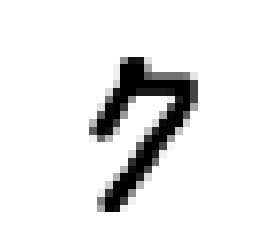

In [44]:
#plot random image
sample_number=6
plt.imshow(img_data[sample_number].reshape(28,28), cmap="gray_r")
plt.axis('off')

img_gt, img_pred= gtlabel[sample_number], pred[sample_number]
print("Image Label:", img_pred)